# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr).

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [83]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import pylab as pl
import astropy.units as u
import astropy.table as tb
from astropy.table import QTable
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

##File of fancy plot style. To use des.mplstyle file you must have an LaTeX distribution in your system
#plt.style.use(machine_path+'/Mestrado/cenarios/mandyoc/scripts_gera_inputs_imgs/new_outputs/des.mplstyle')

In [112]:
def read_params(fpath):
    '''
    Read param.txt and returns Nx, Nz, Lx, Lz of the scenario givem by fpath
    
    Parameters
    ----------
    
    fpath: str
        Path to the param.txt file
    '''
    
    with open(fpath+"param.txt","r") as f:
        line = f.readline()
        line = line.split() #split by space a string to a list of strings
        Nx = int(line[-1])
        
        line = f.readline()
        line = line.split()
        Nz = int(line[-1])

        line = f.readline()
        line = line.split()
        Lx = float(line[-1])

        line = f.readline()
        line = line.split()
        Lz = float(line[-1])

    return Nx, Nz, Lx, Lz


def read_data(prop, step, fpath):
    '''
    Read and reshape read data according to parameters to return a (Nx, Nz) array.
    
    Parameters
    ----------
    
    prop: str
        Property of the mandyoc outputs: temperature, density, strain, strain_rate, viscosity, heat or pressure.
        
    step: str
        Time step of numerical scenario.
        
    fpath: str
        Path to the param.txt file.
    '''
    
    Nx, Nz, Lx, Lz = read_params(fpath)
    file_name = prop+"_"+str(step)+".txt"

    A = np.loadtxt(fpath+file_name, unpack=True, comments="P", skiprows=2)
    TT = A*1.0
    TT[np.abs(TT)<1.0E-200]=0
    TT = np.reshape(TT, (Nx,Nz), order='F')
    TTT = TT[:,:]

    return TTT
        
def read_density(fpath, step, Nx, Nz):
    '''
    Read and reshape readed data according to parameters to return a (Nx, Nz) array.
    
    Parameters
    ----------
    fpath: str
        Path to the param.txt file.
        
    step: str
        Time step of numerical scenario.
        
    Nx: int
        Number of points in x direction.
        
    Nz: int
        Number of points in z direction.
    '''

    Rho = np.loadtxt(fpath+"density_"+str(step)+".txt",skiprows=2, unpack=True, comments="P")
    Rho = np.reshape(Rho, (Nz, Nx))

    return Rho

def read_temperature(fpath, step, Nx, Nz):
    '''
    Read temperature data from temperature_step.txt  and reshape to a (Nz, Nx) array
    
    Parameters
    ----------
    fpath: str
        Path to the param.txt file.
        
    step: str
        Time step of numerical scenario.
        
    Nx: int
        Number of points in x direction.
        
    Nz: int
        Number of points in z direction.
    '''

    Temper = np.loadtxt(fpath+"temperature_"+str(step)+".txt",skiprows=2, unpack=True, comments="P")
    Temper = np.reshape(Temper, (Nz, Nx))

    return Temper

def extract_interface(z, Z, Nx, Rhoi, rho):
    '''
    Extract interface from Rhoi according to a given density (rho)

    Parameters
    ----------
    z: array_like
        Array representing z direction.

    Z: array_like
        Array representing z direction resampled with higher resolution.

    Nx: int
        Number of points in x direction.

    Rhoi: array_like (Nz, Nx)
        Density field from mandyoc

    rho: int
        Value of density to be searched in Rhoi field
    '''

    topo_aux = []

    for j in np.arange(Nx):
        topoi = interp1d(z, Rhoi[:,j]) #return a "function" of interpolation to apply in other array
        idx = (np.abs(topoi(Z)-rho)).argmin()
        topo = Z[idx]
        topo_aux = np.append(topo_aux, topo)

    return topo_aux

def find_nearest(array, value):
    '''Return the index in array nearest to a given value.
    
    Parameters
    ----------
    
    array: array_like
        1D array used to find the index
        
    value: float
        Value to be seached
    '''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def read_times_steps(fpath):
    '''List and sort the time*.txt files
       
       Parameters
       ----------
       fapth: str
           Path to scenario directory.
    '''
    
    steps = []
    times = []
    
    ts = sorted(glob.glob(fpath+"time_*.txt"), key=os.path.getmtime)
    total_curves = len(ts)
    step_initial = int(ts[0].split('/')[-1][5:-4])
    step_final = int(ts[-1].split('/')[-1][5:-4])
    dstep = int(ts[1].split('/')[-1][5:-4]) - int(ts[0].split('/')[-1][5:-4])

    for step in range(step_initial, step_final+1, dstep):
        step = int(step)
        time_fname = "time_" + str(step) + ".txt"
        time = np.loadtxt(fpath+time_fname, usecols=2, max_rows=1)
        time = round(time/1.0E6, 2)
        steps = np.append(steps, int(step))
        times = np.append(times, time)
    steps = np.asarray(steps)
    steps = steps.astype('int')
    return times, steps

def trim_axs(axs, N):
    '''Little helper to index the axs as 1D list
       
       Parameters
       ----------
       axs: `~matplotlib.axes.Axes` list of Axes
           
       N: int
           Total number of subplots.
    '''
    
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def plot_data(fpath, ax, axs, prop, step, xlims, ylims):
    '''
    Plot data from mandyoc according to a given property.

    Parameters
    ----------
    fapth: str
           Path to scenario directory.
    
    ax: `~matplotlib.axes._subplots.AxesSubplot` Axis subplot.
    
    axs: 
        Numpy array of `~matplotlib.axes.Axes` list of Axes after use of trim_axis function.

    prop: str
        Property from mandyoc.     

    step: int
        Step of Mandyoc output files .

    xlims: list
        List with the limits of x axis
        
    ylims: list
        List with the limits of y axis
    '''
    
    #label of colorbars
#     print(prop)
    props_label = {'density':              r'$\mathrm{[kg/m^3]}$',
                   'heat':                 'log(W/kg)',
                   'lithology':            r'log$(\epsilon_{II})$',
                   'pressure':             'P [GPa]',
                   'strain':               r'Accumulated strain [$\varepsilon$]',
                   'strain_rate':          r'log($\dot{\varepsilon}$)',
                   'temperature':          r'$^{\circ}\mathrm{[C]}$',
                   'temperature_anomaly':  r'Temperature anomaly $^{\circ}\mathrm{[C]}$',
                   'topography':           'Topography [km]',
                   'viscosity':            'log(Pa.s)',
                   'vs_anomaly':           r'dVs/Vs [\%]'
                   }
    
    props_cmap = {'density': 'viridis',
                  'heat': 'inferno',
                  'lithology': 'viridis',
                  'pressure': 'viridis',
                  'strain': 'viridis', #Default. Comment this line and uncomment one of the options bellow
#                   'strain': 'cividis',
#                   'strain': 'Greys',
#                   'strain': 'inferno',
#                   'strain': 'magma',
                  'strain_rate': 'viridis',
                  'temperature': 'viridis',
                  'temperature_anomaly': 'RdBu_r',
                  'topography': '',
                  'viscosity': 'viridis'
                   }

    #limits of colorbars
    vals_minmax = {'density':             [0.0, 3378.],
                   'heat':                [np.log10(1.0E-13), np.log10(1.0E-9)],
                   'lithology':           [None, None],
                   'pressure':            [-1.0E-3, 1.0],
                   'strain':              [-3.0, 1.8],
                   'strain_rate':         [np.log10(1.0E-19), np.log10(1.0E-12)],
                   'temperature':         [0, 1600],
                   'temperature_anomaly': [-150, 150],
                   'topography':          [-6, 6],
                   # 'viscosity':           [np.log10(1.0E16), np.log10(1.0E25)],
                   # 'viscosity':           [np.log10(1.0E22), np.log10(1.0E25)],
                   'viscosity':           [np.log10(1.0E18), np.log10(1.0E25)]
                  }

    Nx, Nz, Lx, Lz = read_params(fpath)

    ##Creating a grid to plot
    xi = np.linspace(0, Lx/1000, Nx)
    zi = np.linspace(-Lz/1000+40, 0+40, Nz) #km, +40 to compensate the air layer above sea level
    xx, zz = np.meshgrid(xi, zi)

#             idx = np.where(tab['Steps']==stp[0])[0][0]

    #Removing the mean uplift between of left side
    #condx = (xi >= 100) & (xi <= 600)
    # z_mean = np.mean(topography[condx])
    z_mean = 40.0 #np.mean(topo[condx])
    
    fname = fpath + 'sp_surface_global_' + str(step) + '.txt'
    topo = np.loadtxt(fname, unpack=True, skiprows=2, comments='P')/1.0E3
    topo = topo + 40
    condx = (xi >= 100) & (xi <= 400)
    mean = np.mean(topo[condx])
    topoi = topo - np.abs(mean)
    

    val_minmax = vals_minmax[prop]
    
    if(prop == 'lithology'):
        data = read_data('strain', step, fpath)
        
    elif(prop == 'temperature_anomaly'):
        data = read_data('temperature', step, fpath)
        
    elif(prop == 'topography'):
        topo_from_density = True
        
        if(topo_from_density == True):
            Rhoi = read_density(fpath, step, Nx, Nz)
            interfaces=[2900, 3365]
            ##Extract layer topography
            z = np.linspace(Lz/1000.0, 0, Nz)
            Z = np.linspace(Lz/1000.0, 0, 8001) #zi
            x = np.linspace(Lx/1000.0, 0, Nx)

            topo_interface = extract_interface(z, Z, Nx, Rhoi, 200.) #200 kg/m3 = air/crust interface
            topo_interface -= np.abs(z_mean)
            topo_interface = -1.0*topo_interface

            data = topo_interface
            
        else:
            data = topoi
        
    else:
        data = read_data(prop, step, fpath)
    data[data==0] = 1.0E-28 #avoid log(0)
    
    if(prop == 'lithology' or prop == "strain" or prop == "strain_rate" or prop == "viscosity" or prop == "heat"):
        data = np.log10(data)
    
    #PLOT DATA
    
    if(prop != 'lithology' and prop != 'strain' and prop != 'pressure' and prop != 'temperature_anomaly' and prop != 'topography'): #properties that need a colorbar
        im = ax.imshow(np.transpose(data),
                       cmap = props_cmap[prop], origin='lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = val_minmax[0],
                       vmax = val_minmax[1],
                       aspect = 'auto')

        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 200.) #200 kg/m3 = air/crust interface
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        Temperi = read_temperature(fpath, step, Nx, Nz)
        isotherms=[550, 800, 1300]
        cs = ax.contour(xx, zz, Temperi, 100, levels=isotherms, linewidths = 1.0, colors=['red', 'red', 'red'])
        
        if(ax==axs[0]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
        
#         ax.contour(xx, zz, Rhoi, 100, levels=interfaces, colors=['black', 'red'])

        if(ax == axs[-1]):
        
            ticks = np.linspace(val_minmax[0], val_minmax[1], 5, endpoint=True)
            clb = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.08, pad=0.01, ticks=ticks,
                        format='%.0f')#, label=props_label[prop])
            clb.set_label(props_label[prop], fontsize=12)
            
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]
#         ax.fill_between(xaux, topoi[condaux], 38.5, color='white', alpha=1.0, zorder=51)
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
    elif(prop == 'strain'):
        im = ax.imshow(np.transpose(data),
                       cmap = props_cmap[prop], origin='lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = val_minmax[0],
                       vmax = val_minmax[1],
                       aspect = 'auto')

        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 200.) #200 kg/m3 = air/crust interface
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        Temperi = read_temperature(fpath, step, Nx, Nz)
        isotherms=[550, 800, 1300]
        cs = ax.contour(xx, zz, Temperi, 100, levels=isotherms, linewidths=1.0, colors=['red', 'red', 'red'])
        
        if(ax==axs[0]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
        
#         ax.contour(xx, zz, Rhoi, 100, levels=interfaces, colors=['black', 'red'])
        
        ticks = np.linspace(np.min(data), np.max(data), 5, endpoint=True)
        clb = fig.colorbar(im,
                           ax=ax,
                           orientation='vertical',
                           fraction=0.08,
                           pad=0.01,
                           ticks=ticks,
                           format='%.1f')#, label=props_label[prop])
        
        clb.set_label(props_label[prop], fontsize=12)
            
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]
#         ax.fill_between(xaux, topoi[condaux], 38.5, color='white', alpha=1.0, zorder=51)
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
    
    elif(prop == 'pressure'): #GPa 
        im = ax.imshow(np.transpose(data/1.0E9),
                       cmap=props_cmap[prop],
                       origin='lower',
                       extent=(0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = val_minmax[0],
                       vmax = val_minmax[1],
                       aspect = 'auto')
        
        if(ax == axs[-1]):
            ticks = np.linspace(val_minmax[0], val_minmax[1], 5, endpoint=True)
            clb = fig.colorbar(im,
                               ax=ax,
                               orientation='vertical',
                               fraction=0.08,
                               pad=0.01,
                               ticks=ticks,
                               format='%.3f')
            
            clb.set_label(props_label[prop], fontsize=12)
        
        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
        
        Temperi = read_temperature(fpath, step, Nx, Nz)
        isotherms=[550, 800, 1300]
        cs = ax.contour(xx, zz, Temperi, 100, levels=isotherms, linewidths=1.0, colors=['red', 'red', 'red'])
        
        if(ax==axs[0]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
        
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 200.) #200 kg/m3 = air/crust interface
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]
        
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
        
    elif(prop == 'temperature_anomaly'):
        #removing horizontal mean temperature
        A = data  #shape: (Nx, Nz)
        B = np.transpose(A) #shape: (Nz, Nx)
        C = np.mean(B, axis=1) #shape: 151==Nz
        D = (B.T - C) #B.T (Nx,Nz) para conseguir subtrair C
        
        im = ax.imshow(np.transpose(D), 
                       cmap = props_cmap[prop], 
                       origin = 'lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40), 
                       vmin = val_minmax[0], 
                       vmax = val_minmax[1],
                       aspect = 'auto'
                       )

        if(ax == axs[-1]):
            ticks = np.linspace(val_minmax[0], val_minmax[1], 5, endpoint=True)
            clb = fig.colorbar(im,
                               ax=ax,
                               orientation='vertical',
                               fraction=0.08,
                               pad=0.01,
                               ticks=ticks,
                               format='%.0f')
            
            clb.set_label(props_label[prop], fontsize=12)
        
        Temperi = read_temperature(fpath, step, Nx, Nz)
        isotherms=[550, 800, 1300]
        
        cs = ax.contour(xx,
                        zz,
                        Temperi,
                        100,
                        levels=isotherms,
                        colors=['red', 'red', 'red'])
        
        if(ax==axs[0]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
    elif(prop == 'topography'):
        ax.plot(xx[0], data, alpha = 1, linewidth = 2.0, color = "blueviolet")
        
    elif(prop == 'lithology'): #shaded lithology plot
        cr = 255.
        color_sed = (241./cr,184./cr,68./cr)
        color_dec = (137./cr,81./cr,151./cr)
        color_uc = (228. / cr, 156. / cr, 124. / cr)
        color_lc = (240. / cr, 209. / cr, 188. / cr)
        color_lit = (155. / cr, 194. / cr, 155. / cr)
        color_mlit_uc = 'xkcd:grass green' #(228. / cr, 156. / cr, 124. / cr)
        color_mlit_lc = 'xkcd:darkish green' #(240. / cr, 209. / cr, 188. / cr)
        color_ast = (207. / cr, 226. / cr, 205. / cr)
        
        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces=[2900, 3365]
        
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 200.) #200 kg/m3 = air/crust interface
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0*topo_interface
        
        ax.contourf(xx,
                    zz,
                    Rhoi,
                    #You must choose intermediate values according to the reference densities
                    #adopted in interfaces.txt file, otherwise the colors will not be displayed
                    #correctly
                    levels = [200.,
                              2350, #sed
                              2450, #dec
                              2750, #uc
                              2900, #lc
                              3315, #mlit upper craton
                              3350, #mlit lower craton
                              3365, #mlit non cratonic
                              3900, #asthenosphere
                              ],
                    colors = [
                              color_sed,
                              color_dec,
                              color_uc,
                              color_lc,
                              color_mlit_uc,
                              color_mlit_lc,
                              color_lit,
                              color_ast],
                    # levels = [200., 2350, 2450, 2700, 2800, 3354, 3900],
                    # colors = [color_dec, color_sed, color_uc, color_lc, color_lit, color_ast]
                    )
        
        im=ax.imshow(np.transpose(data),
                     cmap = 'Greys',
                     origin = 'lower',
                     extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40,0 + 40),
                     zorder = 50,
                     alpha = 0.2, vmin=-0.5,
                     vmax = 0.7,
                     aspect = 'auto')


        if(ax == axs[-1]):
            if(len(axs) > 1):

                bv1 = inset_axes(ax,
                            loc='lower right',
                            width="100%",  # respective to parent_bbox width
                            height="100%",  # respective to parent_bbox width
                            bbox_to_anchor=(0.83,#horizontal position respective to parent_bbox or "loc" position
                                            0.09,# vertical position
                                            0.25,# width
                                            0.16),# height
                            bbox_transform=ax.transAxes
                            )
                
                # b1 = [0.89, #horizontal position respective to parent_bbox or "loc" position
                #       0.12, #vertical position
                #       0.08, #width
                #       0.08, #height
                #       ]
            else:
                bv1 = inset_axes(ax,
                            loc='lower right',
                            width="100%",  # respective to parent_bbox width
                            height="100%",  # respective to parent_bbox width
                            bbox_to_anchor=(0.83,#horizontal position respective to parent_bbox or "loc" position
                                            0.09,# vertical position
                                            0.25,# width
                                            0.16),# height
                            bbox_transform=ax.transAxes
                            )
                # b1 = [0.85, 0.2, 0.2, 0.12]
            # bv1 = plt.axes(b1)

            #creating a matrix to plot the lithology legend
            A = np.zeros((100, 10))

            A[:20, :] = 2700
            A[20:40, :] = 2800
            A[40:60, :] = 3300
            A[60:80, :] = 3350
            A[80:100, :] = 3400

            A = A[::-1, :]

            xA = np.linspace(-0.5, 0.9, 10)
            yA = np.linspace(0, 1.5, 100)

            xxA, yyA = np.meshgrid(xA, yA)
            air_threshold = 200
            bv1.contourf(
                xxA,
                yyA,
                A,
                levels = [200.,
                              2350, #sed
                              2450, #dec
                              2750, #uc
                              2900, #lc
                              3315, #mlit upper craton
                              3350, #mlit lower craton
                              3365, #mlit non cratonic
                              3900, #asthenosphere
                              ],
                    colors = [
                              color_sed,
                              color_dec,
                              color_uc,
                              color_lc,
                              color_mlit_uc,
                              color_mlit_lc,
                              color_lit,
                              color_ast],
                # levels=[air_threshold, 2750, 2900, 3365, 3900],
                # colors=[color_uc, color_lc, color_lit, color_ast],

            )

            bv1.imshow(
                xxA[::-1, :],
                extent=[-0.5, 0.9, 0, 1.5],
                zorder=100,
                alpha=0.2,
                cmap=plt.get_cmap("Greys"),
                vmin=-0.5,
                vmax=0.9,
            )

            bv1.set_yticklabels([])
            plt.xlabel(r"log$(\varepsilon_{II})$", size=14)
            bv1.tick_params(axis='x', which='major', labelsize=12)
            bv1.set_xticks([-0.5, 0, 0.5])
            bv1.set_yticks([])
            bv1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

        
        Temperi = read_temperature(fpath, step, Nx, Nz)
        isotherms=[550, 800, 1300]
        cs = ax.contour(xx, zz, Temperi, 100, levels=isotherms, linewidths=0.5, colors=['red', 'red', 'red'])
        
        if(ax==axs[0]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
        
        xaux = xx[0]
        condaux = (xaux>xlims[0]) & (xaux<xlims[1])
        xaux = xaux[condaux]

#         ax.fill_between(xaux, topoi[condaux], 38.5, color='white', alpha=1.0, zorder=51)
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)
    
    else:
        im = ax.imshow(np.transpose(data),
                       cmap = props_cmap[prop],
                       origin = 'lower',
                       extent = (0, Lx / 1.0E3, -Lz / 1.0E3 + 40, 0 + 40),
                       vmin = val_minmax[0],
                       vmax = val_minmax[1],
                       aspect = 'auto')
    
        Rhoi = read_density(fpath, step, Nx, Nz)
        interfaces = [2900, 3365]
        
        ##Extract layer topography
        z = np.linspace(Lz/1000.0, 0, Nz)
        Z = np.linspace(Lz/1000.0, 0, 8001) #zi
        x = np.linspace(Lx/1000.0, 0, Nx)
        
        Temperi = read_temperature(fpath, step, Nx, Nz)
        isotherms=[550, 800, 1300]
        cs = ax.contour(xx, zz, Temperi, 100, levels=isotherms, colors=['red', 'red', 'red'])
        
        if(ax == axs[0]):
            fmt = {}
            for level, isot in zip(cs.levels, isotherms):
                fmt[level] = str(level) + r'$^{\circ}$C'

            ax.clabel(cs, cs.levels, fmt=fmt, inline=True, use_clabeltext=True)
            
        topo_interface = extract_interface(z, Z, Nx, Rhoi, 200.) #200 kg/m3 = air/crust interface
        topo_interface -= np.abs(z_mean)
        topo_interface = -1.0 * topo_interface
        
        xaux = xx[0]
        condaux = (xaux > xlims[0]) & (xaux < xlims[1])
        xaux = xaux[condaux]
        ax.fill_between(xaux, topo_interface[condaux], 35.5, color='white', alpha=1.0, zorder=51)

# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

In [113]:
machine_path

'/home/joao_macedo'

/home/joao_macedo/opt/teste/
teste_lithology


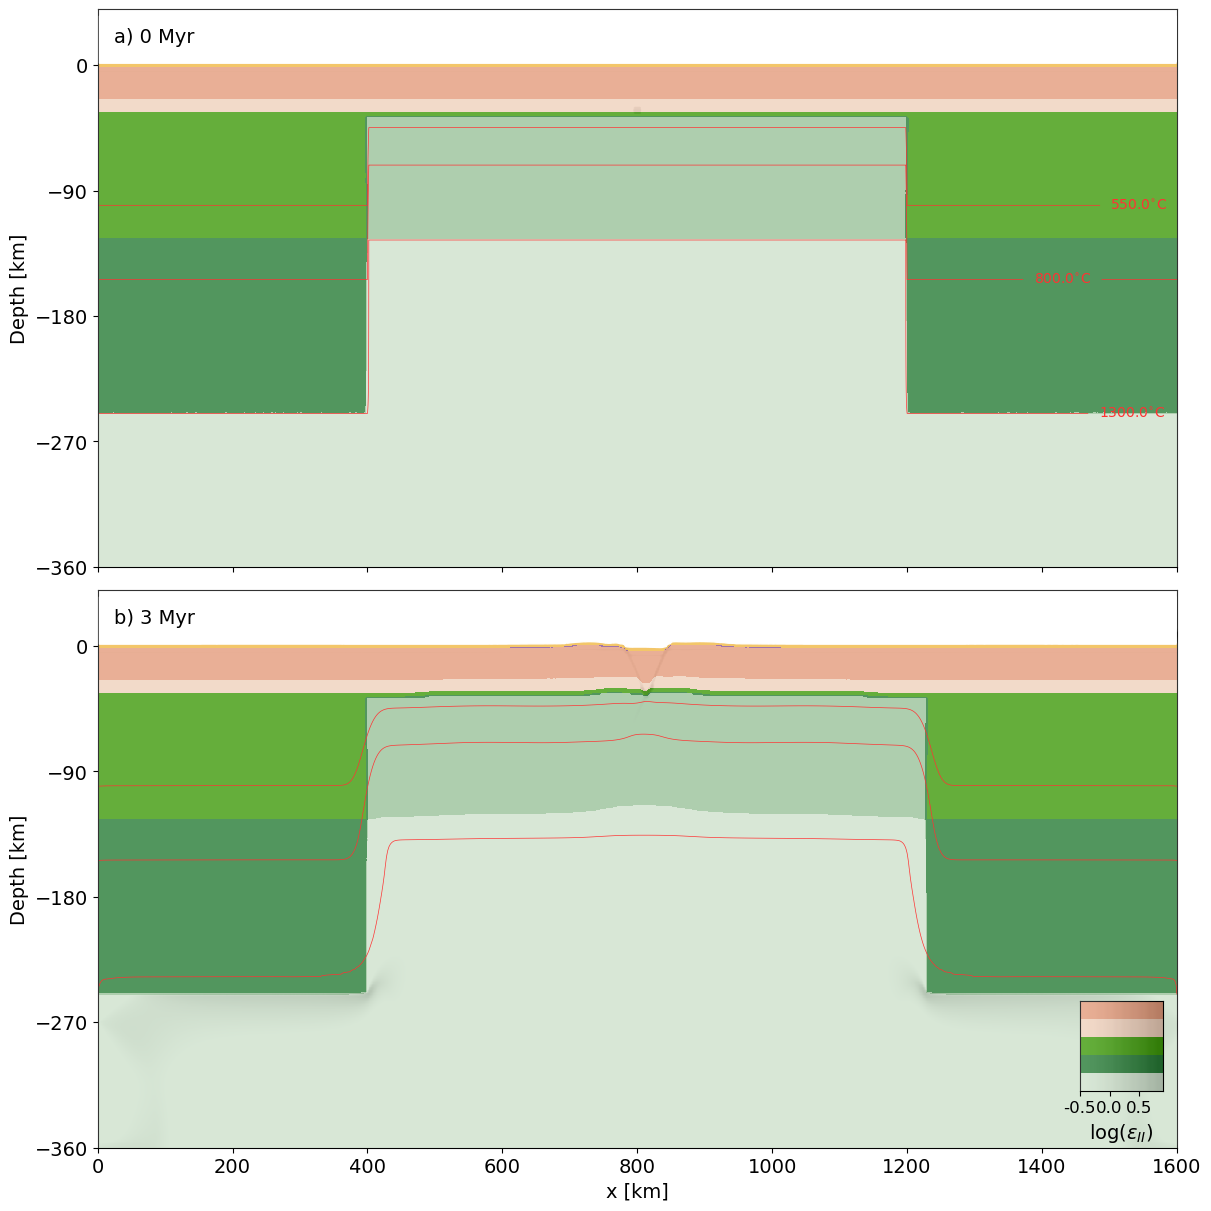

In [123]:
#Set scenario path

#scenario = '/Documents/aguiasala/M45/M45/'
#scenario = '/Documents/Simulations/M60_1x1/'
#scenario = '/Documents/Simulations/Invertedmargin/'
# scenario = '/Documents/Simulations/MR_dk/'
# scenario = '/Desktop/teste/'
scenario = '/opt/teste/'
##############################################################################################################
#Creating path to the experiment

fpath = machine_path + scenario
print(fpath)

##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
prop = 'lithology'
#prop = 'pressure'
#prop = 'strain'
# prop = 'strain_rate'
#prop = 'temperature'
# prop = 'temperature_anomaly'
# prop = 'topography'
# prop = 'viscosity'

##############################################################################################################
#Set instants

#instants = [25,75,105]
#instants = [0,25, 35, 49,120]
# instants = [0,5,10,15]
instants = [0, 3]
# instants = [0, 30, 60, 90, 120] #Myr
# instants = [0, 30, 60, 90, 120, 150]

##############################################################################################################
#Reading scenario basic informations

times, steps = read_times_steps(fpath)
Nx, Nz, Lx, Lz = read_params(fpath)

##############################################################################################################
#Set domain limits of the figure
#Aqui mudamos os limites de x e y de plotagem da figura!
if(prop != 'topography'):
    xlims = [0, Lx / 1.0e3]
    ylims = [-Lz / 1.0e3 + 40, 40]
else:
    xmin = 0 #+ 200
    xmax = Lx / 1.0E3 #- 200
    xlims = [xmin, xmax]
    ylims = [-6, 6]

##############################################################################################################
#Creating figure and subplots
plt.close('all')

if(len(instants) == 1):
    fig, axs = plt.subplots(len(instants), 1, constrained_layout=True, figsize=(12,6), sharex=True, sharey=True)
    axs = [axs]
else:
    fig, axs = plt.subplots(len(instants), 1, constrained_layout=True, figsize=(12,12), sharex=True, sharey=True)
    axs = trim_axs(axs, len(instants))


alphabet = list(string.ascii_lowercase)
letters = alphabet[0: len(instants)]

##############################################################################################################
#Plot data
for instant, ax in zip(instants, axs):
    idx = find_nearest(times, instant)
    step = steps[idx]
    # plot_data(fpath, ax, axs, prop, step, xlims, ylims)
    plot_data(fpath, ax, axs, prop, step, xlims, [ylims])
    #print(steps[idx], times[idx], instant)
    
##############################################################################################################
#Setting plot details

fsize = 14
axs[-1].set_xlabel('x [km]', fontsize=fsize)
for ax, letter, instant in zip(axs, letters, instants):
    label_text = letter + ') ' + str(instant) + ' Myr'
    ax.text(0.015,
            0.95,
            label_text,
            color='k',
            bbox=dict(edgecolor = 'white',
                      facecolor = 'white',
                      alpha = 0.6),
            fontsize=fsize,
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes,
            zorder=52)
    
    if(prop != 'topography'):
        ax.set_ylabel('Depth [km]', fontsize=fsize)
        ax.tick_params(axis='both', labelsize=fsize)
        axs[-1].tick_params(axis='both', labelsize=fsize)
        ax.set_yticks(np.linspace(ylims[0], 0, 5))
    else:
        ax.set_ylabel('Topogarphy [km]', fontsize=fsize)
        ax.tick_params(axis='both', labelsize=fsize)
        axs[-1].tick_params(axis='both', labelsize=fsize)
        ax.set_yticks(np.linspace(ylims[0], ylims[1], 7))
        ax.grid('-k', alpha = 0.7)

axs[0].set_xlim(xlims)
axs[0].set_ylim(ylims)
# axs[0].set_ylim([-40,40])    
##############################################################################################################
#Saving figure

figname = scenario.split('/')[-2] + '_'+prop
print(figname)

#This will save inside the notebook directory
#fig.savefig(figname+'.pdf', dpi=400)
#fig.savefig(figname+'.png', dpi=400)

#This will save inside the experiment directory
#fig.savefig(fpath+figname+'.pdf', dpi=400)
fig.savefig(fpath+figname+'.png', dpi=400)
#fig.savefig(fpath+figname+'.jpeg', dpi=400)